# Analyse Trees

Text

#### Import libaries

In [34]:
import os
import pandas as pd
import shap
import xgboost
import numpy as np
import csv

from xgboost import plot_tree
import matplotlib.pyplot as plt

# Function to calculate the accuracy of the model
def calculate_acc(pred, labels):
    matches = 0
    for i in range(len(labels)):
      if pred[i] == labels[i]:
        matches += 1    
    return matches/len(labels)

## Data Preperation
#### Import the data

In [2]:
path_to_data = "/Users/tim/Documents/HTW_Berlin/2_WS_21_22/projektarbeit_XAI/data_02/Frequency Features/frequencyFeatures.csv"

#read in the data using pandas
df = pd.read_csv(path_to_data)


#check data has been read in properly
df.head()

,ID,Label,Timestamp,xAcc010Hz,xAcc015Hz,xAcc020Hz,xAcc025Hz,xAcc030Hz,xAcc035Hz,xAcc040Hz,...,snd2275Hz,snd2300Hz,snd2325Hz,snd2350Hz,snd2375Hz,snd2400Hz,snd2425Hz,snd2450Hz,snd2475Hz,snd2500Hz
0,1,off,0.00,10.559710,9.695637,2.036690,2.288568,2.565607,2.312750,3.991020,...,0.004249,0.099368,0.012296,0.008071,0.005442,0.026792,0.013993,0.031688,0.007489,0.013386
1,1,off,0.04,2.420781,7.811703,2.076250,2.885846,2.186312,1.296386,2.937785,...,0.013465,0.089160,0.018883,0.018947,0.010409,0.013679,0.017798,0.018390,0.018145,0.007316
2,1,off,0.08,4.148815,6.011957,4.847633,1.743515,1.342447,2.574446,2.829619,...,0.016140,0.075694,0.025835,0.017859,0.015873,0.004619,0.032514,0.008647,0.034637,0.005606
3,1,off,0.12,1.893998,4.014839,9.151205,5.658958,3.151961,3.148572,5.322784,...,0.007497,0.072591,0.031014,0.008861,0.017935,0.000610,0.046791,0.006037,0.028448,0.014418
4,1,off,0.16,7.347695,7.796385,13.865880,11.953800,7.163614,3.821749,9.075362,...,0.019350,0.066571,0.028685,0.034594,0.016541,0.018063,0.035644,0.007217,0.014886,0.024236


#### Delete the features Label Timestamp and the label "off"

ID: <br>
1 --> Off <br>
2 --> On <br>
3 --> Cap <br>
4 --> Out <br>
5 --> Unb <br>
6 --> c25 <br>
7 --> c75 <br>
8 --> vnt <br>

#### Create a panda Frame with only the labels in it

In [3]:
# Delete the two features
df = df.drop(['Label', 'Timestamp'], axis=1)
df

,ID,xAcc010Hz,xAcc015Hz,xAcc020Hz,xAcc025Hz,xAcc030Hz,xAcc035Hz,xAcc040Hz,xAcc045Hz,xAcc050Hz,...,snd2275Hz,snd2300Hz,snd2325Hz,snd2350Hz,snd2375Hz,snd2400Hz,snd2425Hz,snd2450Hz,snd2475Hz,snd2500Hz
0,1,10.559710,9.695637,2.036690,2.288568,2.565607,2.312750,3.991020,5.589097,5.017795,...,0.004249,0.099368,0.012296,0.008071,0.005442,0.026792,0.013993,0.031688,0.007489,0.013386
1,1,2.420781,7.811703,2.076250,2.885846,2.186312,1.296386,2.937785,4.581870,3.691075,...,0.013465,0.089160,0.018883,0.018947,0.010409,0.013679,0.017798,0.018390,0.018145,0.007316
2,1,4.148815,6.011957,4.847633,1.743515,1.342447,2.574446,2.829619,3.864008,5.320990,...,0.016140,0.075694,0.025835,0.017859,0.015873,0.004619,0.032514,0.008647,0.034637,0.005606
3,1,1.893998,4.014839,9.151205,5.658958,3.151961,3.148572,5.322784,5.176761,6.556502,...,0.007497,0.072591,0.031014,0.008861,0.017935,0.000610,0.046791,0.006037,0.028448,0.014418
4,1,7.347695,7.796385,13.865880,11.953800,7.163614,3.821749,9.075362,1.584118,4.653576,...,0.019350,0.066571,0.028685,0.034594,0.016541,0.018063,0.035644,0.007217,0.014886,0.024236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,8,734.684640,385.405156,2422.030460,3666.688023,1331.591958,295.834974,615.946313,8784.043068,12981.346320,...,1.810877,4.199799,3.196192,4.824971,5.501506,2.569931,2.769503,2.864246,4.875627,3.097777
1996,8,427.768727,478.715371,1667.903389,3555.054589,1412.465945,546.736119,755.346273,9108.426555,13018.321490,...,5.296502,1.327645,2.921181,4.135513,7.574796,4.394050,1.986867,3.715002,7.698977,3.895627
1997,8,183.683706,244.413614,1889.702322,3486.772611,1175.411282,844.245959,1166.437422,9453.092350,13172.742710,...,8.563501,3.625357,9.565385,2.401314,8.655602,3.706591,4.951512,3.277185,9.806276,3.751800
1998,8,231.417381,290.299651,2107.940465,3431.216806,1618.341691,977.230736,577.816480,9787.239494,13983.284690,...,8.862310,4.188897,13.152540,1.534665,6.803201,1.311985,3.673036,2.172725,7.631238,0.765262


In [4]:
# Delete 
df = df.iloc[250:, :]
df

,ID,xAcc010Hz,xAcc015Hz,xAcc020Hz,xAcc025Hz,xAcc030Hz,xAcc035Hz,xAcc040Hz,xAcc045Hz,xAcc050Hz,...,snd2275Hz,snd2300Hz,snd2325Hz,snd2350Hz,snd2375Hz,snd2400Hz,snd2425Hz,snd2450Hz,snd2475Hz,snd2500Hz
250,2,454.729201,373.662293,841.151061,740.903054,335.169305,1277.359858,2338.590535,9415.907494,11120.59792,...,2.081464,2.573535,2.920927,4.982745,3.420132,0.867515,4.606851,2.301164,3.850050,2.092610
251,2,183.645769,320.688104,604.463776,746.636921,417.433785,1024.675231,2260.370181,9701.824416,12373.64882,...,1.899494,4.541002,5.725692,3.447297,2.802118,1.385863,2.985951,3.087122,5.687176,1.633761
252,2,192.824680,197.466285,237.154490,545.014362,524.603158,858.507832,356.197129,8766.841994,12655.39475,...,3.947479,4.772883,9.668906,3.489168,2.272290,2.577190,2.675607,5.028594,5.148495,2.285906
253,2,444.692309,607.832208,311.244219,598.615257,557.446143,644.497740,1136.291001,9139.170561,12116.00045,...,3.838190,3.088682,11.496789,2.656639,2.551696,2.951968,3.115344,3.571959,2.862464,4.497884
254,2,806.189855,213.300371,719.645236,379.386502,261.768009,13.231422,569.551468,9577.904815,12135.93629,...,2.575419,2.697834,7.483828,1.691467,2.032943,1.919057,1.855661,0.584894,0.871019,4.263095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,8,734.684640,385.405156,2422.030460,3666.688023,1331.591958,295.834974,615.946313,8784.043068,12981.34632,...,1.810877,4.199799,3.196192,4.824971,5.501506,2.569931,2.769503,2.864246,4.875627,3.097777
1996,8,427.768727,478.715371,1667.903389,3555.054589,1412.465945,546.736119,755.346273,9108.426555,13018.32149,...,5.296502,1.327645,2.921181,4.135513,7.574796,4.394050,1.986867,3.715002,7.698977,3.895627
1997,8,183.683706,244.413614,1889.702322,3486.772611,1175.411282,844.245959,1166.437422,9453.092350,13172.74271,...,8.563501,3.625357,9.565385,2.401314,8.655602,3.706591,4.951512,3.277185,9.806276,3.751800
1998,8,231.417381,290.299651,2107.940465,3431.216806,1618.341691,977.230736,577.816480,9787.239494,13983.28469,...,8.862310,4.188897,13.152540,1.534665,6.803201,1.311985,3.673036,2.172725,7.631238,0.765262


#### Split the data in x,y & train & test

In [5]:
x = df.iloc[:,1:]
x.shape
print(x.iloc[[0]])

      xAcc010Hz   xAcc015Hz   xAcc020Hz   xAcc025Hz   xAcc030Hz    xAcc035Hz  \
250  454.729201  373.662293  841.151061  740.903054  335.169305  1277.359858   

       xAcc040Hz    xAcc045Hz    xAcc050Hz   xAcc055Hz  ...  snd2275Hz  \
250  2338.590535  9415.907494  11120.59792  1928.31614  ...   2.081464   

     snd2300Hz  snd2325Hz  snd2350Hz  snd2375Hz  snd2400Hz  snd2425Hz  \
250   2.573535   2.920927   4.982745   3.420132   0.867515   4.606851   

     snd2450Hz  snd2475Hz  snd2500Hz  
250   2.301164    3.85005    2.09261  

[1 rows x 169 columns]


In [6]:
y = df.iloc[:,0]
y.shape
print(y.iloc[[2]])

252    2
Name: ID, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split

# Split the data in 80% Train and 20% Test Sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

In [8]:
# data must be a numpy array
np_y_test = y_test.to_numpy()

## 1. Analysis Trees with different parameters
### General Parameters: 
**booster:** [default: gbtree]<br>
gbtree = tree based models <br>
gblinear = linear moodels <br>

**silent:** [default: 0]<br>
= 1 --> messages while training <br>
= 0 --> no messages <br>

**nthread** <br>
only for multi core computing <br> <br> <br>

### Booster Parameters: 
**max_depth:** [default: 6]<br>
= maximum number of nodes that are traversed to reach the leaf from the root using the longest path <br>
--> higher depth will allow model to learn relations very specific to a particular sample. <br>
--> Common: 3-10



**eta:** [default: 0.3]<br>
= learning rate <br>
--> Makes the model more robust by shrinking the weights on each step
--> Setting values less than 1.0 has the effect of making less corrections for each tree added to the mode <br>
--> Common: 0.001 to 0.3

**min_child_weight:** [default: 1] <br>
= define minimum sum of weights of all observations required in a child <br>
--> Use to prevent Overfitting <br>
--> too higher values --> Overfitting <br>


**subsample:** [default: 1] <br>
= Denotes the fraction of observations to be randomly samples for each tree. <br>
--> Prevent Overfitting
--> Common: 0.5-1
 
**colsample_bytree:** [default: 1] <br>
= Denotes the fraction of columns to be randomly samples for each tree. <br>
--> Common: 0.5 to 1 <br>

**colsample_bylevel** [default: 1] <br>
Denotes the subsample ratio of columns for each split, in each level. <br>
--> better use colsample_tree do that job <br>

**lambda:** [default=1] <br>
= L2 Regularization <br>
--> Prevent Overfitting

**alpha:** [default = 0] <br>
= L1 Regularization
--> for high dimensionality --> algorithm runs faster <br>

**scale_pos_weight:** [default=1] <br>
A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence <br>


## Test

Acc:  0.9657142857142857


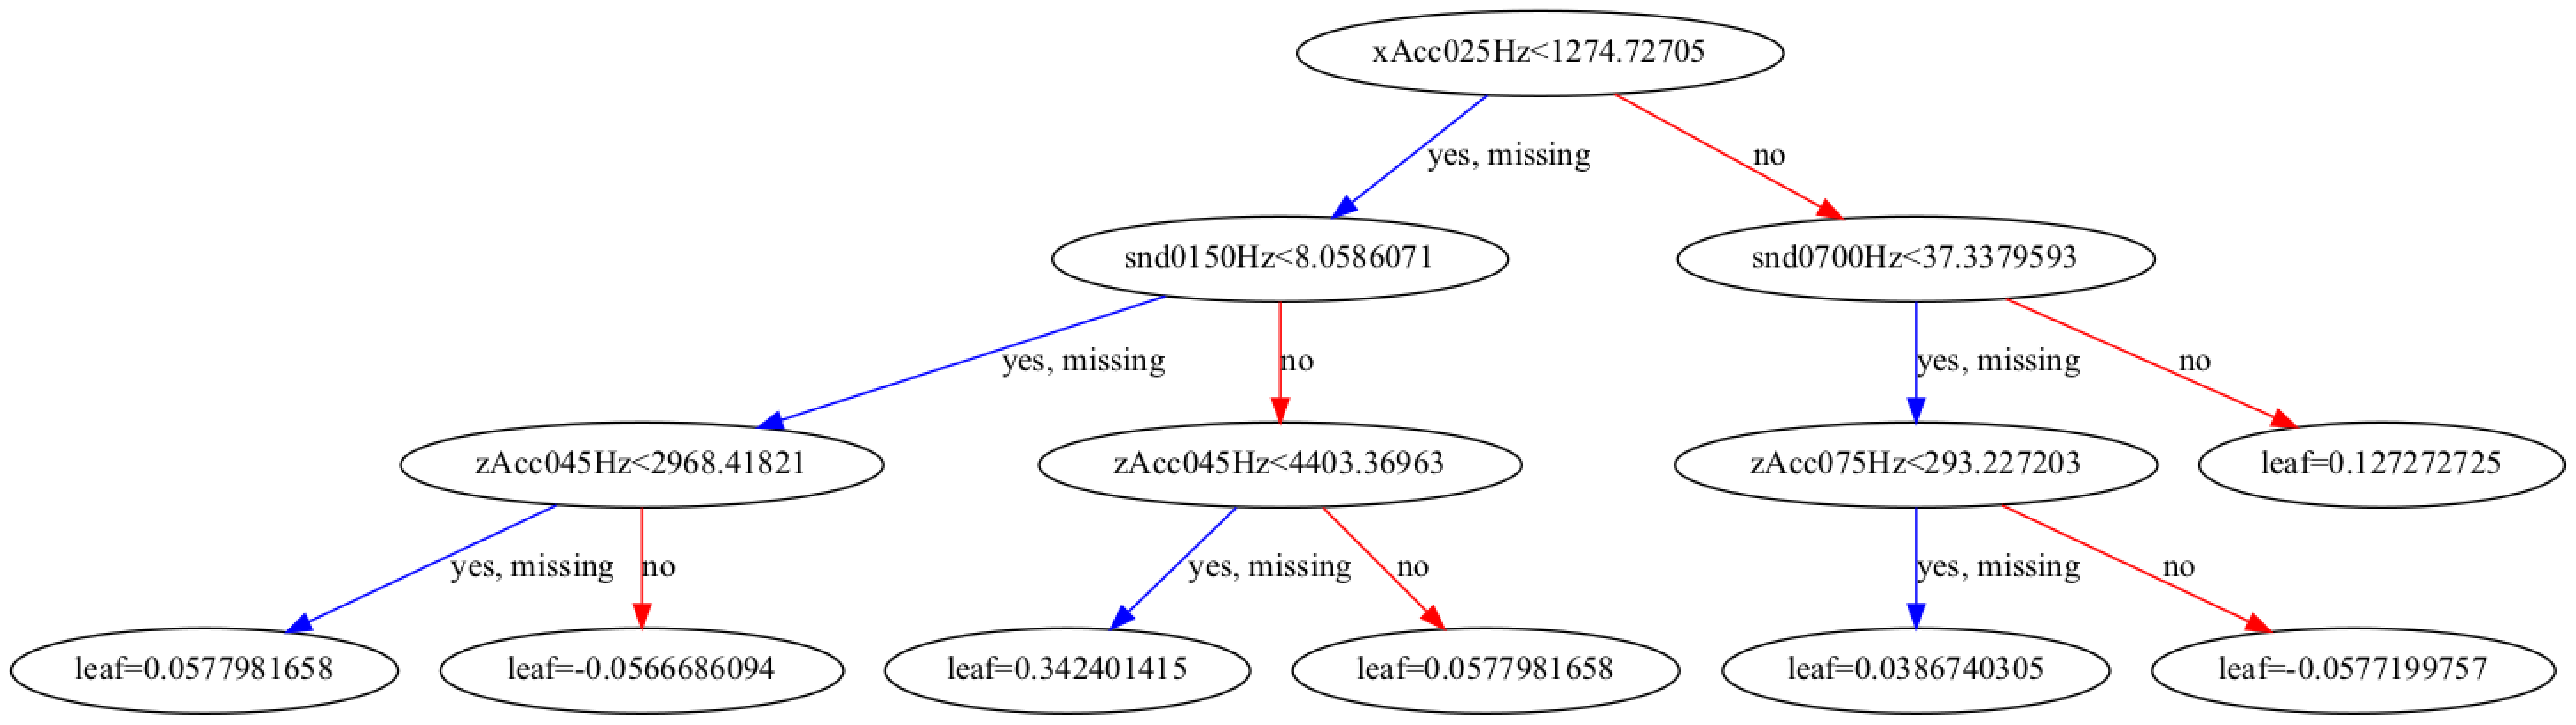

1:Off; 2:On; 3-Cap; 4:Out; 5: Unb; 6: c25; 7: c75; 8: vnt


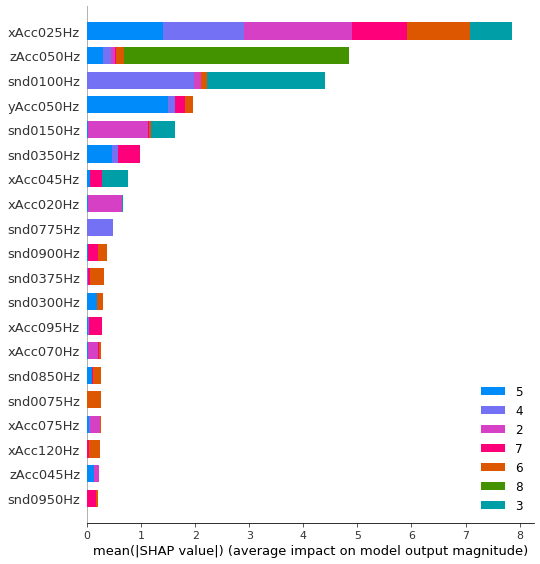

In [9]:
model_test = xgboost.XGBClassifier(silent = 0,
                              max_depth = 3)
model_test.fit(x_train, y_train)

# Plot Acc
print("Acc: ", calculate_acc(model_test.predict(x_test), np_y_test))

# Plot the tree
plot_tree(model_test)
fig = plt.gcf()
fig.set_size_inches(200, 200)
plt.show()

#SHAP
shap_values_test = shap.TreeExplainer(model_test).shap_values(x)
print("1:Off; 2:On; 3-Cap; 4:Out; 5: Unb; 6: c25; 7: c75; 8: vnt")
shap.summary_plot(shap_values_test, x, class_names=model_test.classes_)

### Function to get the information from shap.summary_plot

In [26]:
def get_all_shap(shap_values, max_display=None, silent=None):
    
    """Get the values from the SHAP summary plot, only for multiclass

    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.

    max_display : int
        How many top features to include in the plot (default is 20, or 7 for interaction plots)

    silent : bool
        Print out the calculations
    """
    
    # Start values
    if max_display is None:
        max_display = 2

    if silent is None:
        silent = True



    # get the id of the most important features  [not important: most important]
    feature_order = np.argsort(np.sum(np.mean(np.abs(shap_values), axis=0), axis=0))

    # reverse the array tp [most important, ..., less important]
    feature_order = np.flip(feature_order)

    # get a list with the most important feature names
    feature_names = ['label']
    for i in feature_order[0:max_display]:
        feature_names.append(df.columns[i+1])
        
    # print out the most important features
    if not silent:
        print("Most important features:")
        print(feature_names[1:])

    # get the names of the class
    class_names = model.classes_

    # get only the ids to num_max features
    feature_inds = feature_order[:max_display]

    # get a list with id's of the classes
    class_inds = np.arange(len(class_names))

    # create empty list to store all shap values
    all_shap = []

    # append the feature_names to the list
    all_shap.append(feature_names)


    # i = counter, ind = class_inds 
    for i,ind in enumerate(class_inds):

        # get an array with all the shap-values [shap_value_feature1, shap_value_feature2...]
        global_shap_values = np.abs(shap_values[ind]).mean(0)
        values = global_shap_values[feature_inds]

        # get the class for the array with the shap values
        label=class_names[ind]

        # add the class to the array
        values = np.concatenate((np.array([label]),values) , axis=0)

        # store the values
        all_shap.append(values.tolist())
        
    return all_shap
    


## Trees with different max_depth and eta + No Regularization

In [27]:
plot = False
id = 0
etas = [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.4]

results = pd.DataFrame()

for eta in etas:
    for maximale_depth in range(1,21):
        
        print("_____________________________________________________________________________")
        print("Train new Model: max_depth:", maximale_depth, ', eta:', eta)


        # train the model
        model = xgboost.XGBClassifier(silent = 0,
                                      max_depth = maximale_depth,
                                      eta = eta,
                                      reg_lambda = 0)
        model.fit(x_train, y_train)

        # Calculate Acc
        acc = calculate_acc(model.predict(x_test), np_y_test)
        print("Done training -_> Acc:", acc)

        # safe the tree parameters
        results = results.append([[]], ignore_index=True, sort=False)
        results = results.append([['Class',id, 'Tree', 'max_depth:', maximale_depth, 'eta', eta, 'Regularization', '-','Acc:', acc]], ignore_index=True, sort=False)


        # SHAP
        shap_values = shap.TreeExplainer(model).shap_values(x)

        # Get all the necessary SHAP values
        tree_shap = get_all_shap(shap_values, 10, silent=False)

        results = results.append(tree_shap, ignore_index=True, sort=False)


        if plot:
            # Plot the tree
            plot_tree(model)
            fig = plt.gcf()
            fig.set_size_inches(200, 200)
            plt.show()

            # Plot summary plot
            print("1:Off; 2:On; 3-Cap; 4:Out; 5: Unb; 6: c25; 7: c75; 8: vnt")
            shap.summary_plot(shap_values, x, class_names=model.classes_)

        id =+ 1

        
# safe the results as a csv
results.to_csv('/Users/tim/Desktop/shap_trees_max_depth_eta.csv', sep='\t')

# safe the results as a xlsx
results.to_excel("/Users/tim/Desktop/shap_trees_max_depth_eta.xlsx") 

_____________________________________________________________________________
Train new Model: max_depth: 1 , eta: 0.001
Done training -_> Acc: 0.94
Most important features:
['zAcc050Hz', 'xAcc025Hz', 'snd0100Hz', 'snd0150Hz', 'yAcc050Hz', 'xAcc045Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'yAcc090Hz']
_____________________________________________________________________________
Train new Model: max_depth: 2 , eta: 0.001
Done training -_> Acc: 0.9542857142857143
Most important features:
['xAcc025Hz', 'zAcc050Hz', 'snd0100Hz', 'yAcc050Hz', 'snd0150Hz', 'xAcc020Hz', 'xAcc045Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc070Hz']
_____________________________________________________________________________
Train new Model: max_depth: 3 , eta: 0.001
Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'zAcc050Hz', 'snd0100Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']
_________________________________________________________

Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 8 , eta: 0.005
Done training -_> Acc: 0.9628571428571429
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 9 , eta: 0.005
Done training -_> Acc: 0.9628571428571429
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 10 , eta: 0.005
Done training -_> Acc: 0.9685714285714285


Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 14 , eta: 0.01
Done training -_> Acc: 0.96
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 15 , eta: 0.01
Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 16 , eta: 0.01
Done training -_> Acc: 0.9628571428571429
Most important 

Done training -_> Acc: 0.9685714285714285
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 20 , eta: 0.015
Done training -_> Acc: 0.9714285714285714
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 1 , eta: 0.02
Done training -_> Acc: 0.94
Most important features:
['zAcc050Hz', 'xAcc025Hz', 'snd0100Hz', 'snd0150Hz', 'yAcc050Hz', 'xAcc045Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'yAcc090Hz']
_____________________________________________________________________________
Train new Model: max_depth: 2 , eta: 0.02
Done training -_> Acc: 0.9542857142857143
Most important f

Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc020Hz', 'xAcc045Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 6 , eta: 0.025
Done training -_> Acc: 0.9685714285714285
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 7 , eta: 0.025
Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 8 , eta: 0.025
Done training -_> Acc: 0.9628571428571429
M

Done training -_> Acc: 0.96
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 12 , eta: 0.4
Done training -_> Acc: 0.9628571428571429
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 13 , eta: 0.4
Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 14 , eta: 0.4
Done training -_> Acc: 0.96
Most important features:
['xAcc0

## Trees with different max_depth & eta + L1 Regularization
alpha = 1

In [28]:
plot = False
id = 0
etas = [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.4]

results = pd.DataFrame()

for eta in etas:
    for maximale_depth in range(1,21):
        
        print("_____________________________________________________________________________")
        print("Train new Model: max_depth:", maximale_depth, ', eta:', eta)


        # train the model
        model = xgboost.XGBClassifier(silent = 0,
                                      max_depth = maximale_depth,
                                      eta = eta,
                                      reg_alpha = 1)
        model.fit(x_train, y_train)

        # Calculate Acc
        acc = calculate_acc(model.predict(x_test), np_y_test)
        print("Done training -_> Acc:", acc)

        # safe the tree parameters
        results = results.append([[]], ignore_index=True, sort=False)
        results = results.append([['Class',id, 'Tree', 'max_depth:', maximale_depth, 'eta', eta, 'Regularization', 'L1','Acc:', acc]], ignore_index=True, sort=False)


        # SHAP
        shap_values = shap.TreeExplainer(model).shap_values(x)

        # Get all the necessary SHAP values
        tree_shap = get_all_shap(shap_values, 10, silent=False)

        results = results.append(tree_shap, ignore_index=True, sort=False)


        if plot:
            # Plot the tree
            plot_tree(model)
            fig = plt.gcf()
            fig.set_size_inches(200, 200)
            plt.show()

            # Plot summary plot
            print("1:Off; 2:On; 3-Cap; 4:Out; 5: Unb; 6: c25; 7: c75; 8: vnt")
            shap.summary_plot(shap_values, x, class_names=model.classes_)

        id =+ 1

        
# safe the results as a csv
results.to_csv('/Users/tim/Desktop/shap_trees_max_depth_eta_L1.csv', sep='\t')

# safe the results as a xlsx
results.to_excel("/Users/tim/Desktop/shap_trees_max_depth_eta_L1.xlsx") 

_____________________________________________________________________________
Train new Model: max_depth: 1 , eta: 0.001
Done training -_> Acc: 0.9314285714285714
Most important features:
['zAcc050Hz', 'xAcc025Hz', 'snd0100Hz', 'yAcc050Hz', 'snd0150Hz', 'xAcc045Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'yAcc090Hz']
_____________________________________________________________________________
Train new Model: max_depth: 2 , eta: 0.001
Done training -_> Acc: 0.9571428571428572
Most important features:
['xAcc025Hz', 'zAcc050Hz', 'snd0100Hz', 'yAcc050Hz', 'snd0150Hz', 'xAcc020Hz', 'xAcc045Hz', 'snd0350Hz', 'snd0775Hz', 'zAcc045Hz']
_____________________________________________________________________________
Train new Model: max_depth: 3 , eta: 0.001
Done training -_> Acc: 0.96
Most important features:
['xAcc025Hz', 'zAcc050Hz', 'snd0100Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0775Hz', 'snd0900Hz']
_________________________________________________________

Done training -_> Acc: 0.9571428571428572
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'xAcc095Hz']
_____________________________________________________________________________
Train new Model: max_depth: 8 , eta: 0.005
Done training -_> Acc: 0.96
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'zAcc045Hz']
_____________________________________________________________________________
Train new Model: max_depth: 9 , eta: 0.005
Done training -_> Acc: 0.96
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'xAcc095Hz']
_____________________________________________________________________________
Train new Model: max_depth: 10 , eta: 0.005
Done training -_> Acc: 0.9571428571428572
Most important features:
['x

Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 14 , eta: 0.01
Done training -_> Acc: 0.9628571428571429
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 15 , eta: 0.01
Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 16 , eta: 0.01
Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'snd

Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 20 , eta: 0.015
Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 1 , eta: 0.02
Done training -_> Acc: 0.9314285714285714
Most important features:
['zAcc050Hz', 'xAcc025Hz', 'snd0100Hz', 'yAcc050Hz', 'snd0150Hz', 'xAcc045Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'yAcc090Hz']
_____________________________________________________________________________
Train new Model: max_depth: 2 , eta: 0.02
Done training -_> Acc: 0.9571428571428572
Most important features:
['xAcc025Hz', 'zAcc

Done training -_> Acc: 0.96
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 7 , eta: 0.025
Done training -_> Acc: 0.9571428571428572
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'xAcc095Hz']
_____________________________________________________________________________
Train new Model: max_depth: 8 , eta: 0.025
Done training -_> Acc: 0.96
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'zAcc045Hz']
_____________________________________________________________________________
Train new Model: max_depth: 9 , eta: 0.025
Done training -_> Acc: 0.96
Most important features:
['xAcc025Hz', 'snd

Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 13 , eta: 0.4
Done training -_> Acc: 0.96
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 14 , eta: 0.4
Done training -_> Acc: 0.9628571428571429
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 15 , eta: 0.4
Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050

## Trees with different max_depth & eta + L2 Regularization
lambda = 1

In [29]:
plot = False
id = 0
etas = [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.4]

results = pd.DataFrame()

for eta in etas:
    for maximale_depth in range(1,21):
        
        print("_____________________________________________________________________________")
        print("Train new Model: max_depth:", maximale_depth, ', eta:', eta)


        # train the model
        model = xgboost.XGBClassifier(silent = 0,
                                      max_depth = maximale_depth,
                                      eta = eta,
                                      reg_lambda = 1)
        model.fit(x_train, y_train)

        # Calculate Acc
        acc = calculate_acc(model.predict(x_test), np_y_test)
        print("Done training -_> Acc:", acc)

        # safe the tree parameters
        results = results.append([[]], ignore_index=True, sort=False)
        results = results.append([['Class',id, 'Tree', 'max_depth:', maximale_depth, 'eta', eta, 'Regularization', 'L2','Acc:', acc]], ignore_index=True, sort=False)


        # SHAP
        shap_values = shap.TreeExplainer(model).shap_values(x)

        # Get all the necessary SHAP values
        tree_shap = get_all_shap(shap_values, 10, silent=False)

        results = results.append(tree_shap, ignore_index=True, sort=False)


        if plot:
            # Plot the tree
            plot_tree(model)
            fig = plt.gcf()
            fig.set_size_inches(200, 200)
            plt.show()

            # Plot summary plot
            print("1:Off; 2:On; 3-Cap; 4:Out; 5: Unb; 6: c25; 7: c75; 8: vnt")
            shap.summary_plot(shap_values, x, class_names=model.classes_)

        id =+ 1

        
# safe the results as a csv
results.to_csv('/Users/tim/Desktop/shap_trees_max_depth_eta_L2.csv', sep='\t')

# safe the results as a xlsx
results.to_excel("/Users/tim/Desktop/shap_trees_max_depth_eta_L2.xlsx") 

_____________________________________________________________________________
Train new Model: max_depth: 1 , eta: 0.001
Done training -_> Acc: 0.9314285714285714
Most important features:
['zAcc050Hz', 'xAcc025Hz', 'snd0100Hz', 'snd0150Hz', 'yAcc050Hz', 'xAcc045Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'yAcc090Hz']
_____________________________________________________________________________
Train new Model: max_depth: 2 , eta: 0.001
Done training -_> Acc: 0.9628571428571429
Most important features:
['xAcc025Hz', 'zAcc050Hz', 'snd0100Hz', 'snd0150Hz', 'yAcc050Hz', 'xAcc020Hz', 'xAcc045Hz', 'snd0350Hz', 'snd0775Hz', 'zAcc045Hz']
_____________________________________________________________________________
Train new Model: max_depth: 3 , eta: 0.001
Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'zAcc050Hz', 'snd0100Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0775Hz', 'snd0900Hz']
___________________________________________

Done training -_> Acc: 0.9628571428571429
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 8 , eta: 0.005
Done training -_> Acc: 0.9714285714285714
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 9 , eta: 0.005
Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 10 , eta: 0.005
Done training -_> Acc: 0.9714285714285714


Done training -_> Acc: 0.9628571428571429
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 14 , eta: 0.01
Done training -_> Acc: 0.9628571428571429
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 15 , eta: 0.01
Done training -_> Acc: 0.9685714285714285
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 16 , eta: 0.01
Done training -_> Acc: 0.9657142857142857
M

Done training -_> Acc: 0.9685714285714285
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 20 , eta: 0.015
Done training -_> Acc: 0.9685714285714285
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 1 , eta: 0.02
Done training -_> Acc: 0.9314285714285714
Most important features:
['zAcc050Hz', 'xAcc025Hz', 'snd0100Hz', 'snd0150Hz', 'yAcc050Hz', 'xAcc045Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'yAcc090Hz']
_____________________________________________________________________________
Train new Model: max_depth: 2 , eta: 0.02
Done training -_> Acc: 0.9628571428571429
Mo

Done training -_> Acc: 0.9571428571428572
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 6 , eta: 0.025
Done training -_> Acc: 0.9685714285714285
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 7 , eta: 0.025
Done training -_> Acc: 0.9628571428571429
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 8 , eta: 0.025
Done training -_> Acc: 0.9714285714285714
M

Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 12 , eta: 0.4
Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 13 , eta: 0.4
Done training -_> Acc: 0.9628571428571429
Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
_____________________________________________________________________________
Train new Model: max_depth: 14 , eta: 0.4
Done training -_> Acc: 0.9628571428571429
Most

## Comparison between Regularization Methods
To compare the 3 methods the rows with the features will be extracted and compared to each other.
When two rows are different the regularization methods have an impact to the most important features.

First get all 3 excel files an store them into a pandas dataframe:

In [51]:
L_no = pd.read_excel('/Users/tim/Desktop/shap_trees_max_depth_eta.xlsx', index_col=0)
L1 = pd.read_excel('/Users/tim/Desktop/shap_trees_max_depth_eta_L1.xlsx', index_col=0)
L2 =  pd.read_excel('/Users/tim/Desktop/shap_trees_max_depth_eta_L2.xlsx', index_col=0)

### Compare No Regularization and L1 Regularization

So we see that the Regularization method have an impact to the most important features. <br>
But only beginning from the 4th most important feature. <br>
So the importance of the first 3 features are still the same <br>

With the shap.summary_plot we know that the first 5 features have the biggest impact of the prediction. <br>
The other features have such a less impact that we only compare the first 5 features in the next steps.

#### Lets compare:

In [73]:
def compare_features(frame1, frame2):
    counter = 0
    
    for id in range(2,1400,10):

        # get the two rows
        row_1 = frame1.iloc[id, :]
        row_2 = frame2.iloc[id, :]

        # transform dataframe to list
        row_1 = row_1.values.tolist()
        row_2 = row_2.values.tolist()

        # compare them
        for row_id in range(1,5):
            if row_1[row_id] != row_2[row_id]:
                
                model_1 = frame1.iloc[id-1, :]
                model_2 = frame2.iloc[id-1, :]
                
                print("Found Difference!")
                print("Place: ", row_id)
                print("____________________________________________________________________________")
                print("Model1:", model_1.values.tolist())
                print(row_1)
                print("Model2:", model_2.values.tolist())
                print(row_2)
                print("")
                
                counter = counter + 1
                
    print("Found ", counter, " differences in frames.")
    

print("Comparison L_no and L1")
compare_features(L_no, L1)
print("")
print("")
print("Comparison L_no and L2")
compare_features(L_no, L2)
print("")
print("")
print("Comparison L1 and L2")
compare_features(L1, L2)
print("")
print("")

Comparison L_no and L1
Found Difference!
Place:  4
____________________________________________________________________________
Model1: ['Class', 0, 'Tree', 'max_depth:', 1, 'eta', 0.001, 'Regularization', '-', 'Acc:', 0.94]
['label', 'zAcc050Hz', 'xAcc025Hz', 'snd0100Hz', 'snd0150Hz', 'yAcc050Hz', 'xAcc045Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'yAcc090Hz']
Model2: ['Class', 0, 'Tree', 'max_depth:', 1, 'eta', 0.001, 'Regularization', 'L1', 'Acc:', 0.9314285714285714]
['label', 'zAcc050Hz', 'xAcc025Hz', 'snd0100Hz', 'yAcc050Hz', 'snd0150Hz', 'xAcc045Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'yAcc090Hz']

Found Difference!
Place:  4
____________________________________________________________________________
Model1: ['Class', 1, 'Tree', 'max_depth:', 1, 'eta', 0.005, 'Regularization', '-', 'Acc:', 0.94]
['label', 'zAcc050Hz', 'xAcc025Hz', 'snd0100Hz', 'snd0150Hz', 'yAcc050Hz', 'xAcc045Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'yAcc090Hz']
Model2: ['Class', 1, 'Tree', 'max_depth:

### Conclusion

When we have a look at the differences the max_depth is never over 2 and every differnece is the same: <br>
Model 1:  /4/ yAcc050Hz  /5/ snd0150Hz
Model 2:  /4/ snd0150Hz  /5/ yAcc050Hz <br>

Small trees with only a max_depth of 1 or 2 aren't exact because they have a small number of rules. <br>

In Addition to that there is no difference between two models with another eta values. So that parameter has also no impact. <br>
All in all we can say that the Regularization Method and eta has no impact of the most important features

In [71]:
def compare_features(frame1, frame2):
    counter = 0
    
    for id in range(2,1400,10):

        # get the two rows
        row_1 = frame1.iloc[id, :]
        row_2 = frame2.iloc[id, :]

        # transform dataframe to list
        row_1 = row_1.values.tolist()
        row_2 = row_2.values.tolist()

        # compare them
        for row_id in range(1,len(row_1)):
            if row_1[row_id] != row_2[row_id]:
                
                model_1 = frame1.iloc[id-1, :]
                model_2 = frame2.iloc[id-1, :]
                
                print("Found Difference!")
                print("Place: ", row_id)
                print("____________________________________________________________________________")
                print("Model1:", model_1.values.tolist())
                print(row_1)
                print("Model2:", model_2.values.tolist())
                print(row_2)
                print("")
                
                counter = counter + 1
                
    print("Found ", counter, " differences in frames.")
    

compare_features(L_no, L1)

Found Difference!
Place:  4
____________________________________________________________________________
Model1: ['Class', 0, 'Tree', 'max_depth:', 1, 'eta', 0.001, 'Regularization', '-', 'Acc:', 0.94]
['label', 'zAcc050Hz', 'xAcc025Hz', 'snd0100Hz', 'snd0150Hz', 'yAcc050Hz', 'xAcc045Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'yAcc090Hz']
Model2: ['Class', 0, 'Tree', 'max_depth:', 1, 'eta', 0.001, 'Regularization', 'L1', 'Acc:', 0.9314285714285714]
['label', 'zAcc050Hz', 'xAcc025Hz', 'snd0100Hz', 'yAcc050Hz', 'snd0150Hz', 'xAcc045Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'yAcc090Hz']

Found Difference!
Place:  5
____________________________________________________________________________
Model1: ['Class', 0, 'Tree', 'max_depth:', 1, 'eta', 0.001, 'Regularization', '-', 'Acc:', 0.94]
['label', 'zAcc050Hz', 'xAcc025Hz', 'snd0100Hz', 'snd0150Hz', 'yAcc050Hz', 'xAcc045Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'yAcc090Hz']
Model2: ['Class', 0, 'Tree', 'max_depth:', 1, 'eta', 0.001, 'Re

Found Difference!
Place:  7
____________________________________________________________________________
Model1: ['Class', 1, 'Tree', 'max_depth:', 4, 'eta', 0.015, 'Regularization', '-', 'Acc:', 0.9657142857142857]
['label', 'xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'xAcc045Hz', 'snd0900Hz']
Model2: ['Class', 1, 'Tree', 'max_depth:', 4, 'eta', 0.015, 'Regularization', 'L1', 'Acc:', 0.9685714285714285]
['label', 'xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0775Hz', 'xAcc095Hz']

Found Difference!
Place:  8
____________________________________________________________________________
Model1: ['Class', 1, 'Tree', 'max_depth:', 4, 'eta', 0.015, 'Regularization', '-', 'Acc:', 0.9657142857142857]
['label', 'xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'xAcc045Hz', 'snd0900Hz']
Model2: ['Class', 1, 'Tree', 'max_d

____________________________________________________________________________
Model1: ['Class', 1, 'Tree', 'max_depth:', 12, 'eta', 0.025, 'Regularization', '-', 'Acc:', 0.9628571428571429]
['label', 'xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
Model2: ['Class', 1, 'Tree', 'max_depth:', 12, 'eta', 0.025, 'Regularization', 'L1', 'Acc:', 0.9628571428571429]
['label', 'xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']

Found Difference!
Place:  7
____________________________________________________________________________
Model1: ['Class', 1, 'Tree', 'max_depth:', 13, 'eta', 0.025, 'Regularization', '-', 'Acc:', 0.9657142857142857]
['label', 'xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'snd0775Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0900Hz']
Model2: ['Class', 1, 'Tree', 'max_depth:', 13, 'eta', 0.025,

## Comparison between Trees with different depths
#A bump plot visualize the changes of the most important features with the different depths of the trees:
[https://github.com/kartikay-bagla/bump-plot-python/blob/master/bumpplot.py]

In [74]:
def bumpchart(df, show_rank_axis= True, rank_axis_distance= 1.1, 
              ax= None, scatter= False, holes= False,
              line_args= {}, scatter_args= {}, hole_args= {}):
    
    if ax is None:
        left_yaxis= plt.gca()
    else:
        left_yaxis = ax

    # Creating the right axis.
    right_yaxis = left_yaxis.twinx()
    
    axes = [left_yaxis, right_yaxis]
    
    # Creating the far right axis if show_rank_axis is True
    if show_rank_axis:
        far_right_yaxis = left_yaxis.twinx()
        axes.append(far_right_yaxis)
    
    for col in df.columns:
        y = df[col]
        x = df.index.values
        # Plotting blank points on the right axis/axes 
        # so that they line up with the left axis.
        for axis in axes[1:]:
            axis.plot(x, y, alpha= 0)

        left_yaxis.plot(x, y, **line_args, solid_capstyle='round')
        
        # Adding scatter plots
        if scatter:
            left_yaxis.scatter(x, y, **scatter_args)
            
            #Adding see-through holes
            if holes:
                bg_color = left_yaxis.get_facecolor()
                left_yaxis.scatter(x, y, color= bg_color, **hole_args)

    # Number of lines
    lines = len(df.columns)

    y_ticks = [*range(1, lines + 1)]
    
    # Configuring the axes so that they line up well.
    for axis in axes:
        axis.invert_yaxis()
        axis.set_yticks(y_ticks)
        axis.set_ylim((lines + 0.5, 0.5))
    
    # Sorting the labels to match the ranks.
    left_labels = df.iloc[0].sort_values().index
    right_labels = df.iloc[-1].sort_values().index
    
    left_yaxis.set_yticklabels(left_labels)
    right_yaxis.set_yticklabels(right_labels)
    
    # Setting the position of the far right axis so that it doesn't overlap with the right axis
    if show_rank_axis:
        far_right_yaxis.spines["right"].set_position(("axes", rank_axis_distance))
    
    return axes

It is more complex to extraxt the needed data from the 3 files then to train new models with only the information we need:


In [81]:
def get_all_shap2(shap_values, max_display=None, silent=None):
    
    """Get the values from the SHAP summary plot, only for multiclass

    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.

    max_display : int
        How many top features to include in the plot (default is 20, or 7 for interaction plots)

    silent : bool
        Print out the calculations
    """
    
    # Start values
    if max_display is None:
        max_display = 2

    if silent is None:
        silent = True

    feature_order = np.argsort(np.sum(np.mean(np.abs(shap_values), axis=0), axis=0))

    feature_order = np.flip(feature_order)

    feature_names = ['label']
    for i in feature_order[0:max_display]:
        feature_names.append(df.columns[i+1])

    if not silent:
        print("Most important features:")
        print(feature_names[1:])

    class_names = model.classes_
    feature_inds = feature_order[:max_display]
    class_inds = np.arange(len(class_names))
    all_shap = []
    all_shap.append(feature_names)

    for i,ind in enumerate(class_inds):
        global_shap_values = np.abs(shap_values[ind]).mean(0)
        values = global_shap_values[feature_inds]
        label=class_names[ind]
        #all_shap.append(values.tolist())
        
    return all_shap
    




plot = False
id = 0


results = pd.DataFrame()


for maximale_depth in range(1,11):

    print("_____________________________________________________________________________")
    print("Train new Model: max_depth:", maximale_depth)


    # train the model
    model = xgboost.XGBClassifier(silent = 0,
                                  max_depth = maximale_depth)
    model.fit(x_train, y_train)

    # Calculate Acc
    acc = calculate_acc(model.predict(x_test), np_y_test)
    print("Done training -_> Acc:", acc)

    # safe the tree parameters
    results = results.append([[]], ignore_index=True, sort=False)
    results = results.append([['Class',id, 'Tree', 'max_depth:', maximale_depth,'Acc:', acc]], ignore_index=True, sort=False)


    # SHAP
    shap_values = shap.TreeExplainer(model).shap_values(x)

    # Get all the necessary SHAP values
    tree_shap = get_all_shap2(shap_values, 10, silent=False)

    results = results.append(tree_shap, ignore_index=True, sort=False)

    id =+ 1

        

# safe the results as a xlsx
results.to_excel("/Users/tim/Desktop/shap_trees_max_depth.xlsx")

_____________________________________________________________________________
Train new Model: max_depth: 1
Done training -_> Acc: 0.9314285714285714
Most important features:
['zAcc050Hz', 'xAcc025Hz', 'snd0100Hz', 'snd0150Hz', 'yAcc050Hz', 'xAcc045Hz', 'snd0350Hz', 'xAcc020Hz', 'snd0775Hz', 'yAcc090Hz']
_____________________________________________________________________________
Train new Model: max_depth: 2
Done training -_> Acc: 0.9628571428571429
Most important features:
['xAcc025Hz', 'zAcc050Hz', 'snd0100Hz', 'snd0150Hz', 'yAcc050Hz', 'xAcc020Hz', 'xAcc045Hz', 'snd0350Hz', 'snd0775Hz', 'zAcc045Hz']
_____________________________________________________________________________
Train new Model: max_depth: 3
Done training -_> Acc: 0.9657142857142857
Most important features:
['xAcc025Hz', 'zAcc050Hz', 'snd0100Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'xAcc020Hz', 'snd0775Hz', 'snd0900Hz']
_____________________________________________________________________________
Trai

In [99]:
bump_data = pd.read_excel('/Users/tim/Desktop/feature_ranking_max_depth.xlsx', index_col=0)
bump_data = bump_data.transpose()
bump_data

,zAcc050Hz,xAcc025Hz,snd0100Hz,snd0150Hz,yAcc050Hz,xAcc045Hz,snd0350Hz,xAcc020Hz,snd0775Hz,snd0900Hz
1,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,NaN
2,2.0,1.0,3.0,4.0,5.0,7.0,8.0,6.0,9.0,NaN
3,2.0,1.0,3.0,5.0,4.0,7.0,6.0,8.0,9.0,NaN
4,3.0,1.0,2.0,5.0,4.0,7.0,6.0,8.0,9.0,10.0
5,3.0,1.0,2.0,5.0,4.0,7.0,6.0,9.0,8.0,10.0
6,3.0,1.0,2.0,5.0,4.0,7.0,6.0,9.0,8.0,10.0
7,3.0,1.0,2.0,5.0,4.0,8.0,6.0,9.0,7.0,10.0
8,3.0,1.0,2.0,5.0,4.0,7.0,6.0,9.0,8.0,10.0
9,3.0,1.0,2.0,5.0,4.0,8.0,6.0,9.0,7.0,10.0
10,3.0,1.0,2.0,5.0,4.0,7.0,6.0,9.0,8.0,10.0


In [106]:
# get the acc for trees with different depths
acc_data = pd.read_excel('/Users/tim/Desktop/acc.xlsx', index_col=0)
acc_data

,1,2,3,4,5,6,7,8,9,10
Acc,0.931429,0.962857,0.965714,0.957143,0.957143,0.968571,0.962857,0.971429,0.965714,0.971429


[<matplotlib.lines.Line2D at 0x7fa6c53028d0>]

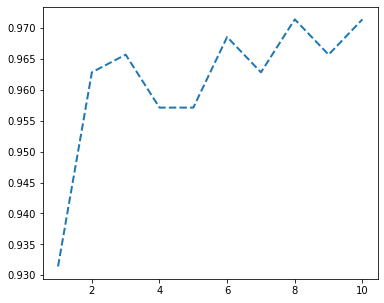

In [183]:
plt.figure(figsize=(6, 5))

y = acc_data.values.tolist()
y = y[0]
x = [1,2,3,4,5,6,7,8,9,10]

plt.plot(x, y, '--', linewidth= 2 )

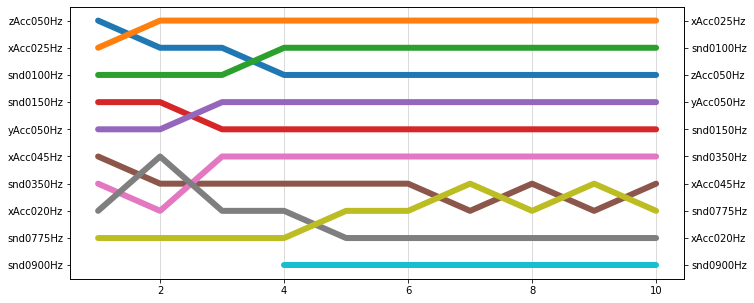

In [179]:

plt.figure(figsize=(11, 5))

[laxis, raxis] = bumpchart(bump_data, show_rank_axis= False,
                           scatter= False,
                           holes = True,
                           line_args= {"linewidth": 6, "alpha": 1})

laxis.xaxis.grid(color='lightgray', linestyle='solid')

plt.show()

## Other things

In [12]:
# Search for code
import inspect

code = inspect.getsource(xgboost.XGBClassifier)
print(code)


class XGBClassifier(XGBModel, XGBClassifierBase):
    # pylint: disable=missing-docstring,too-many-arguments,invalid-name,too-many-instance-attributes
    __doc__ = "Implementation of the scikit-learn API for XGBoost classification.\n\n" \
        + '\n'.join(XGBModel.__doc__.split('\n')[2:])

    def __init__(self, max_depth=3, learning_rate=0.1, n_estimators=100,
                 verbosity=1, silent=None,
                 objective="binary:logistic", booster='gbtree',
                 n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0,
                 subsample=1, colsample_bytree=1, colsample_bylevel=1,
                 colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                 base_score=0.5, random_state=0, seed=None, missing=None, **kwargs):
        super(XGBClassifier, self).__init__(
            max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators,
            verbosity=verbosity, silent=silent, objective=objec